# Introduction to rio-tiler

The goal of this notebook is to give a quick introduction of the main rio-tiler features.

In [11]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Requirements

To be able to run this notebook you'll need the following requirements:
- rio-tiler~= 2.0

In [12]:
# !pip install rio-tiler

In [13]:
import morecantile
from rio_tiler.io import COGReader
from rio_tiler.profiles import img_profiles
from rio_tiler.models import ImageData, Metadata

## Data

For this demo we will use some NAIP data hosted on Azure.

https://azure.microsoft.com/fr-fr/services/open-datasets/catalog/naip/


The data is similar to the data hosted on [AWS](https://registry.opendata.aws/naip/), but using the one on Azure is easier because it offers direct `http` access without needing an AWS account.

In [14]:
# For this DEMO we will use this file
src_path = "https://naipblobs.blob.core.windows.net/naip/v002/al/2019/al_60cm_2019/30087/m_3008701_ne_16_060_20191115.tif"

## rio_tiler.io.COGReader

In `rio-tiler` 2.0 we introduced COGReader, which is a python class providing usefull methods to read and inspect any GDAL/rasterio raster dataset.

Docs: [https://cogeotiff.github.io/rio-tiler/readers/#cogreader](https://cogeotiff.github.io/rio-tiler/readers/#cogreader) 

In [15]:
?COGReader

### Info

Read GDAL/Rasterio dataset metadata

In [16]:
# As for Rasterio, using context manager is a good way to 
# make sure the dataset are closed when we exit.
with COGReader(src_path) as cog:
    print("rasterio dataset:")
    print(cog.dataset)
    
    print("metadata from rasterio:")
    print(cog.dataset.meta)
    
    # Using rio-tiler Info() method
    info = cog.info()
    print("rio-tiler dataset info:")
    print(cog.info().dict())

print(cog.dataset.closed)

rasterio dataset:
<open DatasetReader name='https://naipblobs.blob.core.windows.net/naip/v002/al/2019/al_60cm_2019/30087/m_3008701_ne_16_060_20191115.tif' mode='r'>
metadata from rasterio:
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 10710, 'height': 12300, 'count': 4, 'crs': CRS.from_epsg(26916), 'transform': Affine(0.6, 0.0, 410238.0,
       0.0, -0.6, 3430182.0)}
rio-tiler dataset info:
{'bounds': (-87.94024818743995, 30.93522814625122, -87.87233769345906, 31.002283423611786), 'center': (-87.9062929404495, 30.968755784931503, 12), 'minzoom': 12, 'maxzoom': 18, 'band_metadata': [('1', {}), ('2', {}), ('3', {}), ('4', {})], 'band_descriptions': [('1', ''), ('2', ''), ('3', ''), ('4', '')], 'dtype': 'uint8', 'nodata_type': 'None', 'colorinterp': ['red', 'green', 'blue', 'undefined'], 'scale': None, 'offset': None, 'colormap': None}
True


### Metadata

Read dataset GDAL Metadata and return basic data statistics

In [17]:
with COGReader(src_path) as cog:
    meta = cog.metadata(max_size=256)
    # output from metadata() method is a pydantic model
    # Checkout the docs https://cogeotiff.github.io/rio-tiler/models/#metadata
    assert isinstance(meta, Metadata)
    print(meta.dict(exclude_none=True))

{'bounds': (-87.94024818743995, 30.93522814625122, -87.87233769345906, 31.002283423611786), 'center': (-87.9062929404495, 30.968755784931503, 12), 'minzoom': 12, 'maxzoom': 18, 'band_metadata': [('1', {}), ('2', {}), ('3', {}), ('4', {})], 'band_descriptions': [('1', ''), ('2', ''), ('3', ''), ('4', '')], 'dtype': 'uint8', 'nodata_type': 'None', 'colorinterp': ['red', 'green', 'blue', 'undefined'], 'statistics': {'1': {'percentiles': [34.0, 140.0], 'min': 12.0, 'max': 218.0, 'std': 23.07991495485485, 'histogram': [[988.0, 4058.0, 9413.0, 26485.0, 11632.0, 2905.0, 1072.0, 481.0, 44.0, 10.0], [12.0, 32.6, 53.2, 73.80000000000001, 94.4, 115.0, 135.60000000000002, 156.20000000000002, 176.8, 197.4, 218.0]]}, '2': {'percentiles': [69.0, 142.0], 'min': 32.0, 'max': 210.0, 'std': 17.003989204996465, 'histogram': [[205.0, 816.0, 3946.0, 12095.0, 26092.0, 12497.0, 1260.0, 144.0, 29.0, 4.0], [32.0, 49.8, 67.6, 85.4, 103.2, 121.0, 138.8, 156.60000000000002, 174.4, 192.20000000000002, 210.0]]}, '3'

#### Plot Histogram values

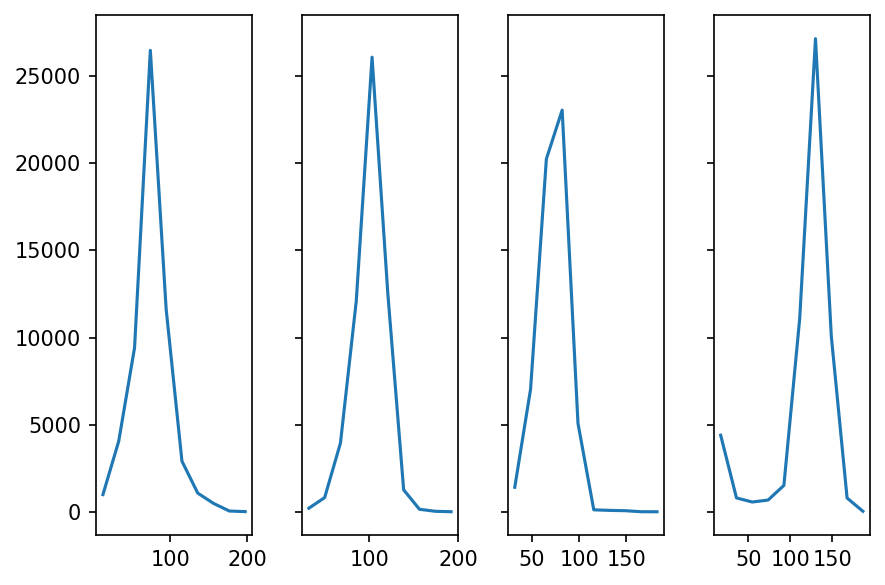

In [18]:
fig, axs = plt.subplots(1, 4, sharey=True, tight_layout=True, dpi=150)
# Red
axs[0].plot(meta.statistics["1"].histogram[1][0:-1], meta.statistics["1"].histogram[0])

# Green
axs[1].plot(meta.statistics["2"].histogram[1][0:-1], meta.statistics["2"].histogram[0])

# Blue
axs[2].plot(meta.statistics["3"].histogram[1][0:-1], meta.statistics["3"].histogram[0])

# NIR
axs[3].plot(meta.statistics["4"].histogram[1][0:-1], meta.statistics["4"].histogram[0])

### Preview

Read a low resolution version of the data (useful when working with COG, because this method will only fetch the overview layer it needs)

In [19]:
with COGReader(src_path) as cog:
    # By default `preview()` will return an array with its longest dimension lower or equal to 1024px
    img = cog.preview()
    print(img.data.shape)
    assert isinstance(img, ImageData)

(4, 1024, 892)


#### The ImageData class

To ease data manipulation, `rio-tiler` version 2.0 uses a new `ImageData` class that holds the arrays returned by rio-tiler/rasterio low level functions.

Docs: https://cogeotiff.github.io/rio-tiler/models/#imagedata

In [20]:
print(f"width: {img.width}")
print(f"height: {img.height}")
print(f"bands: {img.count}")
print(f"crs: {img.crs}")
print(f"bounds: {img.bounds}")

print(type(img.data))
print(type(img.mask))

width: 892
height: 1024
bands: 4
crs: EPSG:26916
bounds: BoundingBox(left=410238.0, bottom=3422802.0, right=416664.0, top=3430182.0)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


#### Display the data

<class 'rio_tiler.models.ImageData'>
(4, 1024, 892)
<class 'numpy.ndarray'>
(1024, 892, 4)


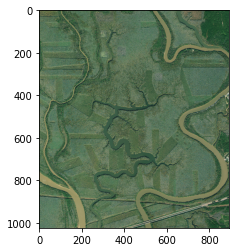

In [21]:
# Rasterio doesn't use the same axis order than visualization libraries (e.g matplotlib, PIL)
# in order to display the data we need to change the order (using rasterio.plot.array_to_image).
# the ImageData class wraps the rasterio function in the `data_as_image()` method.
print(type(img))
print(img.data.shape)

image = img.data_as_image()
# data_as_image() returns a numpy.ndarray
print(type(image))
print(image.shape)

# Use only the first 3 bands (RGB)
imshow(image[:,:,0:3])

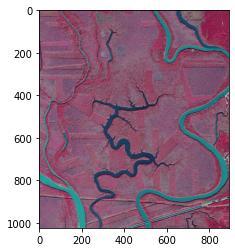

In [22]:
# Display NRG image
# The NAIP imagery has 4 bands Red, Green, Blue, NIR
imshow(image[:,:,[3,0,1]])

#### Using Expression

`rio-tiler` reader methods accept `indexes` option to select the bands you want to read, but also `expression` to perform band math.

In [23]:
with COGReader(src_path) as cog:
    # Return only the last band
    nir_band = cog.preview(indexes=4)
    print(nir_band.data.shape)
    print(nir_band.data.dtype)

(1, 1024, 892)
uint8


(1, 1024, 892)
float64
NDVI range:  -0.6951219512195121 0.9148936170212766


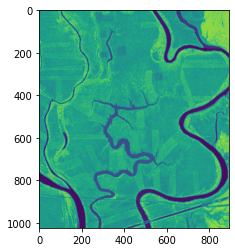

In [24]:
with COGReader(src_path) as cog:
    # Apply NDVI band math
    # (NIR - RED) / (NIR + RED)
    ndvi = cog.preview(expression="(b4-b1)/(b4+b1)")
    print(ndvi.data.shape)
    print(ndvi.data.dtype)
    print("NDVI range: ", ndvi.data.min(), ndvi.data.max())

image = ndvi.post_process(in_range=(-1,1))
imshow(image.data[0])

### Tile

Read data for a specific slippy map tile coordinates

In [25]:
with COGReader(src_path) as cog:
    print(f"MinZoom (WebMercator): {cog.minzoom}")
    print(f"MaxZoom (WebMercator): {cog.maxzoom}")
    print(f"Bounds: {cog.bounds}")

MinZoom (WebMercator): 12
MaxZoom (WebMercator): 18
Bounds: (-87.94024818743995, 30.93522814625122, -87.87233769345906, 31.002283423611786)


In [26]:
# rio-tiler defaults to the WebMercator Grids. The grid definition is provided by the morecantile module
# Docs: https://github.com/developmentseed/morecantile
tms = morecantile.tms.get("WebMercatorQuad")
print(repr(tms))

# Get the list of tiles for the COG minzoom 
with COGReader(src_path) as cog:
    tile_cover = list(tms.tiles(*cog.bounds, zooms=cog.minzoom))

print(f"Nb of Z{cog.minzoom} Mercator tiles: {len(tile_cover)}")
print(tile_cover)

<TileMatrixSet title='Google Maps Compatible for the World' identifier='WebMercatorQuad'>
Nb of Z12 Mercator tiles: 4
[Tile(x=1047, y=1676, z=12), Tile(x=1047, y=1677, z=12), Tile(x=1048, y=1676, z=12), Tile(x=1048, y=1677, z=12)]


In [27]:
with COGReader(src_path) as cog:
    img_1 = cog.tile(*tile_cover[0])
    print(img_1.data.shape)

    img_2 = cog.tile(*tile_cover[1])
    print(img_2.data.shape)

(4, 256, 256)
(4, 256, 256)


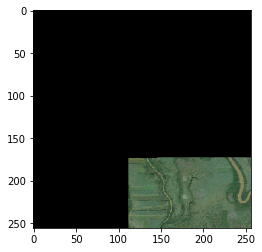

In [28]:
imshow(img_1.data_as_image()[:,:,0:3])

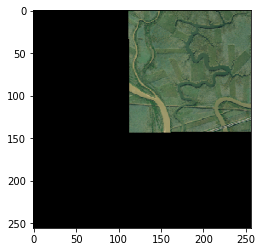

In [29]:
imshow(img_2.data_as_image()[:,:,0:3])

(1, 256, 256)


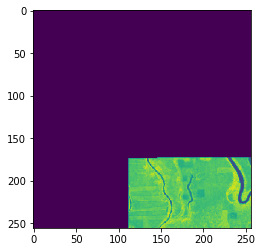

In [30]:
with COGReader(src_path) as cog:
    ndvi = cog.tile(*tile_cover[0], expression="(b4-b1)/(b4+b1)")
    print(ndvi.data.shape)

image = ndvi.post_process(in_range=(-1,1))
imshow(image.data[0])

### Part 

Read data for a given bounding box

In [31]:
with COGReader(src_path) as cog:
    # As for the `preview()` method, the `part()` method will limit the output array to `max_size=1024`
    img = cog.part((-87.92238235473633, 30.954131465929947, -87.87843704223633, 30.97996389724008))
    print(img.data.shape)
    print(img.bounds)
    print(img.crs)

(4, 602, 1024)
BoundingBox(left=-87.92238235473633, bottom=30.954131465929947, right=-87.87843704223633, top=30.97996389724008)
EPSG:4326


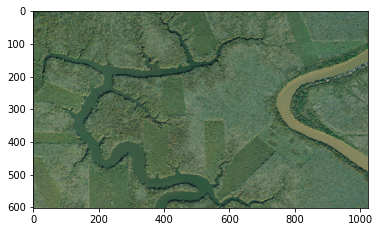

In [32]:
imshow(img.data_as_image()[:,:,0:3])

### Point

Read the pixel value for a specific lon/lat coordinate

In [33]:
with COGReader(src_path) as cog:
    # As for the `preview()` method, the `part()` method will limit the output array to `max_size=1024`
    values = cog.point(-87.92238235473633, 30.954131465929947)
print(values)

[88, 117, 83, 134]


### Feature/GeoJSON

Read value for a geojson feature defined area

In [34]:
feat = {"type":"Feature","properties":{},"geometry":{"type":"Polygon","coordinates":[[[-87.91989326477051,30.977388327504983],[-87.92341232299805,30.9747390975502],[-87.92015075683594,30.97282571907513],[-87.91723251342773,30.971869015455276],[-87.9192066192627,30.96914603729001],[-87.92032241821289,30.965466213678003],[-87.91869163513184,30.960093416531947],[-87.91577339172363,30.957885330068873],[-87.91028022766113,30.95700208119036],[-87.90839195251465,30.955971613842785],[-87.91105270385741,30.954646710918635],[-87.91508674621582,30.954793923262105],[-87.92135238647461,30.953321789618688],[-87.92126655578612,30.947506639952913],[-87.92324066162108,30.94353152388283],[-87.9224681854248,30.9393353886492],[-87.92109489440918,30.936832343075928],[-87.92075157165527,30.9326359137502],[-87.91646003723145,30.934034743992026],[-87.91534423828124,30.937494920341457],[-87.91611671447754,30.941764752554082],[-87.91053771972656,30.943973211611713],[-87.91414260864258,30.948242754412334],[-87.91671752929688,30.949862186261473],[-87.91191101074219,30.949494135978654],[-87.90899276733398,30.950377454275596],[-87.90349960327147,30.95045106376507],[-87.90298461914062,30.953174575006617],[-87.89912223815918,30.953763432093723],[-87.89543151855469,30.953027360167685],[-87.89122581481934,30.955529981576515],[-87.89551734924316,30.959651803323208],[-87.89912223815918,30.960903035444577],[-87.90238380432129,30.95979900795299],[-87.90633201599121,30.96053502769875],[-87.9082202911377,30.963479049959364],[-87.91345596313477,30.964877428739207],[-87.91259765625,30.967306143211744],[-87.9085636138916,30.965466213678003],[-87.90547370910643,30.96553981154008],[-87.90667533874512,30.96885165662014],[-87.90684700012207,30.97039714501039],[-87.89517402648926,30.972972903396382],[-87.89328575134277,30.97643166961476],[-87.8957748413086,30.979080852589725],[-87.89852142333984,30.977093972252376],[-87.90006637573242,30.97643166961476],[-87.9019546508789,30.978712914907245],[-87.90633201599121,30.97805062350409],[-87.90461540222168,30.975107050552193],[-87.90521621704102,30.97422396096446],[-87.90796279907227,30.976358080149122],[-87.90976524353026,30.976063721719164],[-87.90907859802245,30.973856004558257],[-87.9111385345459,30.974076778572197],[-87.91379928588867,30.975769362381378],[-87.9177474975586,30.97643166961476],[-87.91929244995116,30.977314738776947],[-87.91989326477051,30.977388327504983]]]}}

In [38]:
with COGReader(src_path) as cog:
    # we use the feature to define the bounds and the mask
    # but we use `dst_crs` options to keep the projection from the input dataset
    img = cog.feature(feat, dst_crs=cog.dataset.crs)
    print(img.data.shape)
    print(img.bounds)
    print(img.crs)

(4, 1024, 617)
BoundingBox(left=411781.73976479494, bottom=3422476.744499202, right=414897.9890042926, top=3427649.325405782)
EPSG:26916


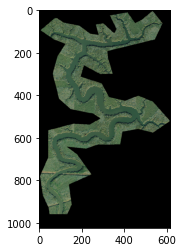

In [39]:
imshow(img.data_as_image()[:,:,0:3])